In [1]:
%load_ext ipydex.displaytools
from sympy import *
import symbtools as st
from IPython.display import display
init_printing()

In [2]:
import control as ctr
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def row_select(mat, rows):
    return st.row_col_select(mat, list(rows), range(mat.cols))

def translate(x, y, z):
    return Matrix([[1, 0, 0, x],
                   [0, 1, 0, y],
                   [0, 0, 1, z],
                   [0, 0, 0, 1]])

def get_translation(mat):
    return st.row_col_select(mat, [0, 1, 2], [3])

def get_rotation(mat):
    return st.row_col_select(mat, [0, 1, 2], [0, 1, 2])

In [4]:
def tf_to_symbolic_mat(tf_object):
    """Übersetzt ein (MIMO) TransferFunction-Objekt des control-Pakets in ein symbolisches Matrix-Objekt aus dem SymPy-Paket.
    Einstellungen zur Abtastzeit dt werden dabei ignoriert."""
    s = Symbol('s')
    numerator_coefficients = tf_object.num
    denominator_coefficients = tf_object.den
    
    rows = len(numerator_coefficients)
    columns = len(numerator_coefficients[0])
    
    matrix = []
    
    for i in range(rows):
        matrix.append([])
        for j in range(columns):
            numerator_ij = numerator_coefficients[i][j]
            denominator_ij = denominator_coefficients[i][j]
            
            numerator_poly = sum([c*s**k for k, c in enumerate(reversed(numerator_ij))])
            denominator_poly = sum([c*s**k for k, c in enumerate(reversed(denominator_ij))])
            
            matrix_entry = numerator_poly / denominator_poly
            matrix[i].append(matrix_entry)
            
    return Matrix(matrix)

def symbolic_to_tf_mat(sym_object, s=None):
    """Übersetzt eine symbolische Übertragungsmatrix, dargestellt als SymPy-Matrix mit gebrochenrationalen Einträgen, in
    ein TransferFunction-Objekt aus dem control-Paket."""
    if s is None:
        s = list(sym_object.free_symbols)[0]  # Annahme: s ist einzige freie Variable in symbolischem Ausdruck
    
    rows = sym_object.rows
    columns = sym_object.cols
    
    sym_object = together(sym_object)  # Eventuell notwendig, wenn noch Doppelbrüche o. Ä. vorhanden sind
    
    numerator_matrix = []
    denominator_matrix = []
    
    for i in range(rows):
        numerator_matrix.append([])
        denominator_matrix.append([])
        for j in range(columns):
            symbolic_entry = sym_object[i, j]
            
            numerator_poly, denominator_poly = fraction(symbolic_entry)
            numerator_coefficients = [float(n) for n in Poly(numerator_poly, s).all_coeffs()]  # all_coeffs liefert SymPy floats
            denominator_coefficients = [float(n) for n in Poly(denominator_poly, s).all_coeffs()]
            
            numerator_matrix[i].append(numerator_coefficients)
            denominator_matrix[i].append(denominator_coefficients)
    
    return ctr.tf(numerator_matrix, denominator_matrix)

def symbolic_to_tf(sym_expr, s=None):
    return symbolic_to_tf_mat(Matrix([[sym_expr]]), s)

Zuerst mal alle Symbole definieren

In [5]:
t = Symbol("t")

xc, yc, zc, xf, yf, zf, xb, yb, zb = p = st.symb_vector('x_c y_c z_c x_f y_f z_f x_b y_b z_b')
xcd, ycd, zcd, xfd, yfd, zfd, xbd, ybd, zbd = pd = st.time_deriv(p, p)

pc = row_select(p, range(0, 3))
pf = row_select(p, range(3, 6))
pb = row_select(p, range(6, 9))

phi, eps, lamb = q = st.symb_vector("varphi varepsilon lambda")
phid, epsd, lambd = qd = st.time_deriv(q, q)
phidd, epsdd, lambdd = qdd = st.time_deriv(q, q, order=2)

lc, lh, lp, dc, dh = symbols("l_c, l_h, l_p, d_c, d_h")
mc, mh = symbols("m_c, m_h")
Ffs, Fbs = symbols("F_f, F_b")

g = symbols("g")

Aufstellen der Transformationsmatrizen

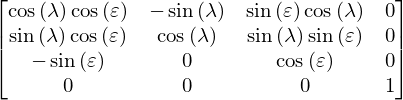

---


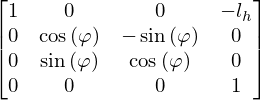

---


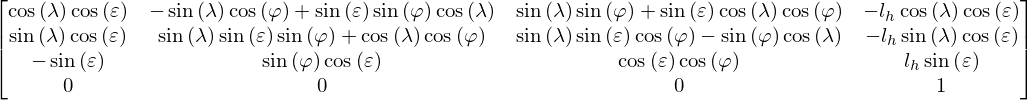

---


In [6]:
rot_phi = Matrix([[1, 0, 0, 0],
                  [0, cos(phi), -sin(phi), 0],
                  [0, sin(phi), cos(phi), 0],
                  [0, 0, 0, 1]])

rot_eps = Matrix([[cos(eps), 0, sin(eps), 0],
                  [0, 1, 0, 0],
                  [-sin(eps), 0, cos(eps), 0],
                  [0, 0, 0, 1]])

rot_lamb = Matrix([[cos(lamb), -sin(lamb), 0, 0],
                   [sin(lamb), cos(lamb), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])

IA = rot_lamb * rot_eps ##:
AH = translate(-lh, 0, 0) * rot_phi ##:
IH = IA * AH ##:

Definition der Transformationsgleichungen für Koordinaten und erste Zeitableitungen

In [7]:
pc_from_q = get_translation(IA * translate(lc, 0, -dc))
pf_from_q = get_translation(IH * translate(0, lp, dh))
pb_from_q = get_translation(IH * translate(0, -lp, dh))

p_from_q = Matrix([pc_from_q[0], pc_from_q[1], pc_from_q[2], pf_from_q[0], pf_from_q[1], pf_from_q[2], pb_from_q[0], pb_from_q[1], pb_from_q[2]])

p_to_q_subs = list(zip(p, p_from_q))

pd_to_qd_subs = list(zip(pd, p_from_q.jacobian(q) * qd))

Langrange-Funktion in redundanten Koordinaten

In [8]:
T = S(1)/S(2)*(mc*(xcd**2+ycd**2+zcd**2)+
               mh/2*(xfd**2+yfd**2+zfd**2)+
               mh/2*(xbd**2+ybd**2+zbd**2))
V = mc*g*zc+mh/2*g*zf+mh/2*g*zb
L_redundant = T - V

Substitution und Darstellung in Minimalkoordinaten

In [9]:
L = L_redundant.subs(p_to_q_subs).subs(pd_to_qd_subs).simplify()

Definition der Rotorkräfte

In [10]:
F_direction_local = Matrix([0, 0, 1])
F_direction = get_rotation(IH) * F_direction_local

Ff = Ffs * F_direction
Fb = Fbs * F_direction

Rotorkräfte in redundanten Koordinaten

In [11]:
F_redundant = st.row_stack(Matrix([0, 0, 0]), Ff, Fb)

Rotorkräfte in Minimalkoordinaten

In [12]:
fp = (F_redundant.T * p_from_q.diff(phi))[0].simplify() ##:
fe = (F_redundant.T * p_from_q.diff(eps))[0].simplify() ##:
fl = (F_redundant.T * p_from_q.diff(lamb))[0].simplify() ##:

---


---


---


Aufstellen der Bewegungsgleichungen

In [13]:
L_d_l = L.diff(lamb).simplify()
L_d_dl = L.diff(lambd).simplify()

L_d_e = L.diff(eps).simplify()
L_d_de = L.diff(epsd).simplify()

L_d_p = L.diff(phi).simplify()
L_d_dp = L.diff(phid).simplify()

erster_term_l = st.time_deriv(L_d_dl, q)
erster_term_e = st.time_deriv(L_d_de, q)
erster_term_p = st.time_deriv(L_d_dp, q)

Eq_l = Eq(erster_term_l - L_d_l, fl)
Eq_e = Eq(erster_term_e - L_d_e, fe)
Eq_p = Eq(erster_term_p - L_d_p, fp)

Transform equations of motion to form $M \ddot q = b$

In [14]:
Eq_p_expanded = Eq(Eq_p.lhs.expand().collect(list(qdd)), Eq_p.rhs)
Eq_e_expanded = Eq(Eq_e.lhs.expand().collect(list(qdd)), Eq_e.rhs)
Eq_l_expanded = Eq(Eq_l.lhs.expand().collect(list(qdd)), Eq_l.rhs)
M, b = linear_eq_to_matrix([Eq_p_expanded, Eq_e_expanded, Eq_l_expanded], list(qdd))

And now to $M \ddot q + C + G = f$

In [15]:
b_no_centripetal = b.subs(list(zip(qd, [0, 0, 0])))
C = -(b - b_no_centripetal)
b_no_gravity = b.subs(g, 0)
G = -(b - b_no_gravity)
f = Matrix([fp, fe, fl])

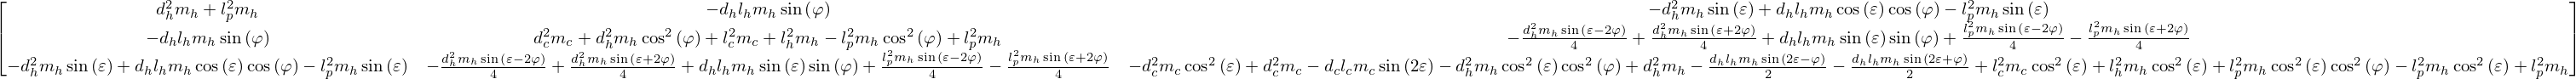

In [13]:
M

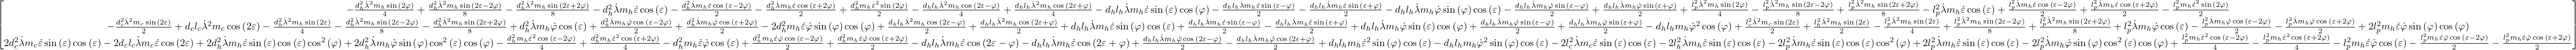

In [14]:
C

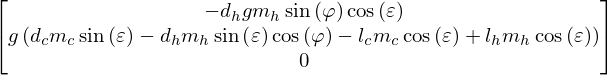

In [15]:
simplify(G)

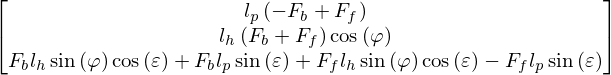

In [16]:
simplify(f)

# Parameter identification?

With $m_h$ and $m_c$

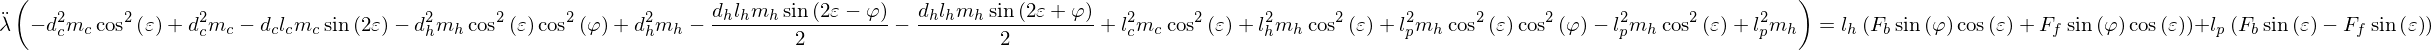

In [40]:
Eq_p_ident_decoupled = Eq(Eq_p.lhs.subs([(edds, 0), (eds, 0), (ldds, 0), (lds, 0)]).simplify().expand().collect([pdds]), Eq_p.rhs)
Eq_e_ident_decoupled = Eq(Eq_e.lhs.subs([(pdds, 0), (pds, 0), (ldds, 0), (lds, 0)]).simplify().expand().collect([edds, sin(es), cos(es)]), Eq_e.rhs)
Eq_l_ident_decoupled = Eq(Eq_l.lhs.subs([(pdds, 0), (pds, 0), (edds, 0), (eds, 0)]).simplify().expand().collect([ldds]), Eq_l.rhs.collect([lp, lh]))

display(Eq_p_ident_decoupled)
display(Eq_e_ident_decoupled)
display(Eq_l_ident_decoupled)

In [48]:
Eq_p_ident = Eq(Eq_p_ident_decoupled.lhs.subs(es, 0), Eq_p_ident_decoupled.rhs)
Eq_e_ident = Eq(Eq_e_ident_decoupled.lhs.subs([(ps, 0)]), Eq_e_ident_decoupled.rhs)
Eq_l_ident = Eq(Eq_l_ident_decoupled.lhs.subs([(ps, 0),(es, 0)]), Eq_l_ident_decoupled.rhs)

display(Eq_p_ident)
display(Eq_e_ident)
display(Eq_l_ident)

In [57]:
p_phi_1, p_phi_2, mu_phi = [Symbol(tex) for tex in [r"p_{\varphi,1}", r"p_{\varphi,2}", r"\mu_\varphi"]]
p_eps_1, p_eps_2, p_eps_3, mu_eps = [Symbol(tex) for tex in [r"p_{\varepsilon,1}", r"p_{\varepsilon,2}", r"p_{\varepsilon,3}", r"\mu_\varepsilon"]]
p_lamb_1, mu_lamb = [Symbol(tex) for tex in [r"p_{\lambda,1}", r"\mu_\lambda"]]

In [58]:
eq_phi_1 = Eq(p_phi_1, dh^2*mh+lp**2*mh)
eq_phi_2 = Eq(p_phi_2, -dh*mh*g)
eq_eps_1 = Eq(p_eps_1, mh*dh**2+mc*dc**2+mc*lc**2+mh*lh**2)
eq_eps_2 = Eq(p_eps_2, g*(mc*dc-mh*dh))
eq_eps_3 = Eq(p_eps_3, g*(mh*lh-mc*lc))
eq_lamb_1 = Eq(p_lamb_1, mc*lc**2+mh*lh**2+mh*lp**2)

In [60]:
sol = solve([eq_eps_1, eq_eps_2, eq_eps_3], [lc, dc, mc])

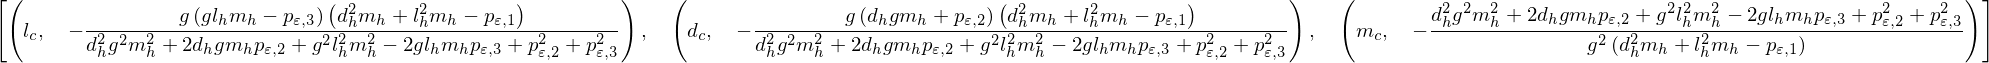

In [65]:
list(zip([lc, dc, mc], sol[0]))

In [66]:
sol = solve([eq_lamb_1, eq_eps_2, eq_eps_3], [lc, dc, mc])

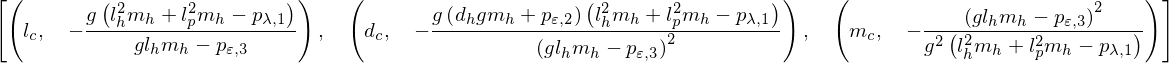

In [68]:
list(zip([lc, dc, mc], sol[0]))

With $m_h$, $m_a$ and $m_c$

In [69]:
ma = Symbol('m_a')

In [71]:
eq_eps_1 = Eq(p_eps_1, mh*dh**2+mc*dc**2+mc*lc**2+mh*lh**2+ma*lh**2)
eq_eps_2 = Eq(p_eps_2, g*(mc*dc-mh*dh))
eq_eps_3 = Eq(p_eps_3, g*((mh+ma)*lh-mc*lc))
eq_lamb_1 = Eq(p_lamb_1, mc*lc**2+mh*lh**2+mh*lp**2+ma*lh**2)

In [74]:
sol = solve([eq_eps_1, eq_eps_2, eq_eps_3, eq_lamb_1], [ma, mc, lc, dc])

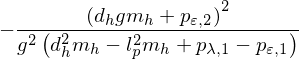

In [83]:
sol[1][1]

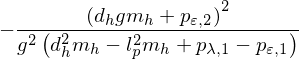

In [84]:
sol[0][1]

In [100]:
sol = solve([eq_eps_3, eq_lamb_1], [ma, lc])

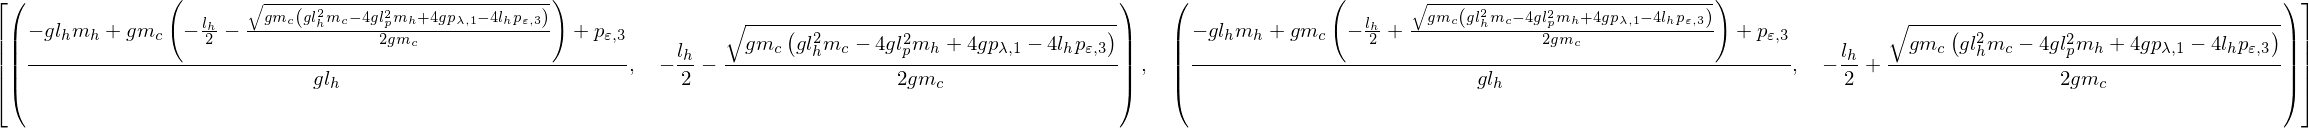

In [101]:
sol

In [95]:
sol = solve(eq_eps_3, ma)

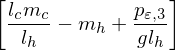

In [96]:
sol

# Simplification justifications

In [55]:
param_symbols = [lh, lc, lp, dc, dh, mh, mc, g]
param_values = [0.66, 0.41, 0.178, 0.07, 0.0027, 1.2, 1.76, 9.81]
param_subs = list(zip(param_symbols, param_values))

deg = pi/180
angle_symbols = list(q)
velo_symbols = list(qd)
acc_symbols = list(qdd)
angle_subs_0 = list(zip(angle_symbols, [0, 0, 0]))
angle_subs_1 = list(zip(angle_symbols, [45*deg, 20*deg, 0]))
angle_subs_2 = list(zip(angle_symbols, [45*deg, 10*deg, 0]))
velo_subs_0 = list(zip(velo_symbols, [0, 0, 0]))
velo_subs_1 = list(zip(velo_symbols, [20*deg, 5*deg, 45*deg]))
velo_subs_2 = list(zip(velo_symbols, [0, 0, 120*deg]))
acc_subs_1 = list(zip(acc_symbols, [0.9, 0.15, 0.4]))

Mass matrix for all angles 0

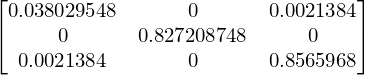

---
\left[\begin{matrix}0.038029548 & 0 & 0.0021384\\0 & 0.827208748 & 0\\0.0021384 & 0 & 0.8565968\end{matrix}\right]


In [60]:
mass_matrix_0 = N(M.subs(param_subs).subs(angle_subs_0)) ##:
print(latex(mass_matrix_0))

Mass matrix for $\varphi=45°$, $\varepsilon=20°$

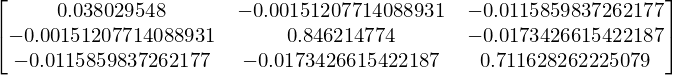

---
\left[\begin{matrix}0.038029548 & -0.00151207714088931 & -0.0115859837262177\\-0.00151207714088931 & 0.846214774 & -0.0173426615422187\\-0.0115859837262177 & -0.0173426615422187 & 0.711628262225079\end{matrix}\right]


In [29]:
mass_matrix_1 = N(M.subs(param_subs).subs(angle_subs_1)) ##:
print(latex(mass_matrix_1))

Mass matrix for $\varphi=45°$, $\varepsilon=10°$

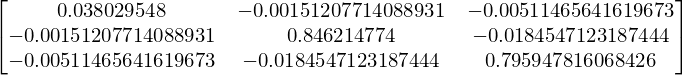

---
\left[\begin{matrix}0.038029548 & -0.00151207714088931 & -0.00511465641619673\\-0.00151207714088931 & 0.846214774 & -0.0184547123187444\\-0.00511465641619673 & -0.0184547123187444 & 0.795947816068426\end{matrix}\right]


In [32]:
mass_matrix_2 = N(M.subs(param_subs).subs(angle_subs_2)) ##:
print(latex(mass_matrix_2))

Magnitude of centripetal forces for $\dot\varphi=20°/s$, $\dot\varepsilon=5°/s$, $\dot\lambda=45°/s$

In [56]:
C_check = N(C.subs(param_subs).subs(angle_subs_2).subs(velo_subs_1))

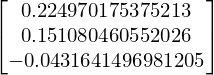

In [62]:
mass_matrix_0.inv() * C_check

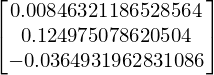

In [63]:
C_check

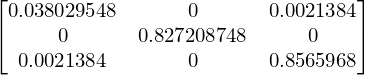

In [64]:
mass_matrix_0

Magnitude of centripetal forces for $\dot\lambda=120°/s$

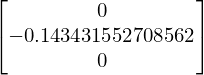

In [22]:
N(C.subs(param_subs).subs([(phi, 0), (eps, -6*deg), (lamb, 0)]).subs(velo_subs_2))

Magnitude of gravity

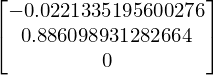

In [31]:
N(G.subs(param_subs).subs(angle_subs_2))

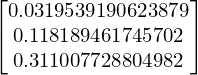

In [37]:
N((M * qdd).subs(param_subs).subs(angle_subs_2).subs(acc_subs_1))

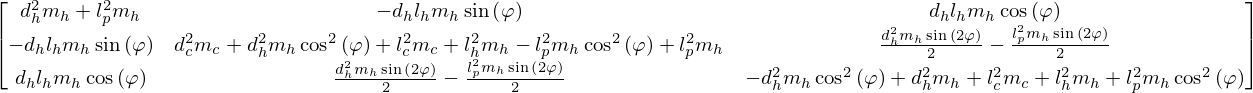

In [39]:
M.subs([(eps, 0)])

# Linearized model

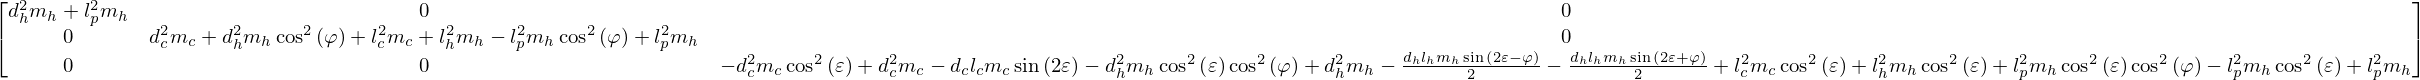

---


In [18]:
M_diag = Matrix([[M[0,0], 0, 0],[0, M[1,1], 0], [0, 0, M[2,2]]]) ##:

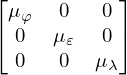

---


In [19]:
mu = mup, mue, mul = st.symb_vector('mu_varphi, mu_varepsilon, mu_lambda')
Mu = diag(*list(mu)) ##:

---


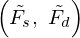

---


In [20]:
q_diff = st.symb_vector('\\tilde\\varphi \\tilde\\varepsilon \\tilde\\lambda') ##:
Fs, Fd = st.symb_vector('F_s F_d')
Fs_diff, Fd_diff = st.symb_vector('\\tilde{F_s}, \\tilde{F_d}') ##:

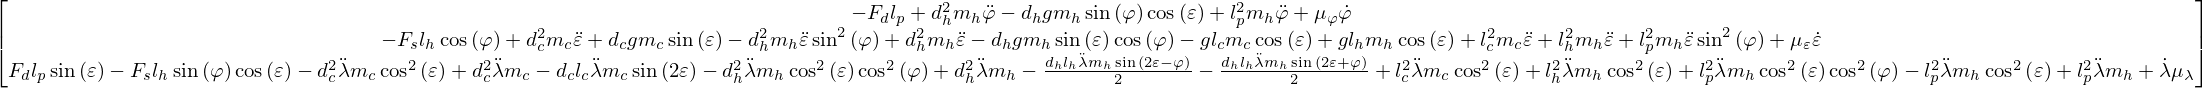

---


In [21]:
F = simplify((M_diag * qdd + Mu * qd + G - f).subs([(Ffs, (Fs+Fd)/2), (Fbs, (Fs-Fd)/2)])) ##: == 0

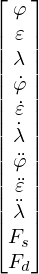

---


In [20]:
variables = st.row_stack(q, qd, qdd, Fs, Fd) ##:
s = Symbol('s')
eps_op, Fs_op = st.symb_vector('varepsilon^* F_s^*')

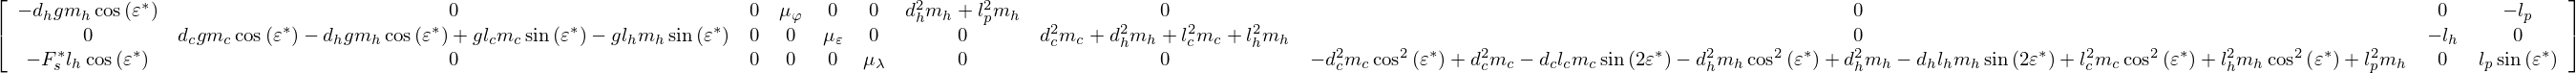

---


In [21]:
jacobian_op = F.jacobian(variables).subz(variables, [0, eps_op, 0, 0, 0, 0, 0, 0, 0, Fs_op, 0]) ##:

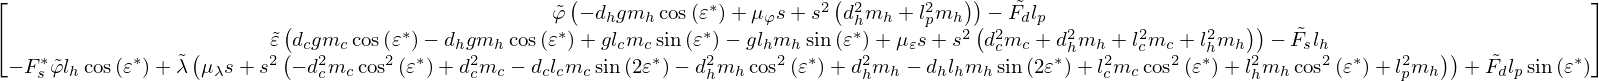

---


In [22]:
F_lin = jacobian_op * st.row_stack(q_diff, q_diff*s, q_diff*s**2, Fs_diff, Fd_diff)
F_lin = Matrix([F_lin_i.collect(q_diff) for F_lin_i in F_lin]) ##:

Some analysis

In [25]:
param_symbols = [lh, lc, lp, dc, dh, mh, mc, g, mup, mue, mul]
param_values = [0.66, 0.41, 0.178, 0.07, 0.0027, 1.2, 1.76, 9.81, 0.033, 0.075, 0.018]
param_subs = list(zip(param_symbols, param_values))

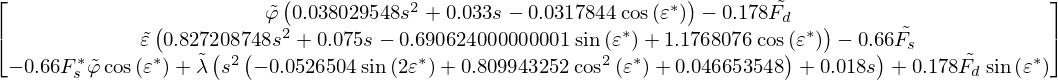

In [24]:
F_lin.subs(param_subs)

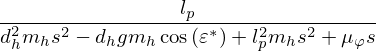

---


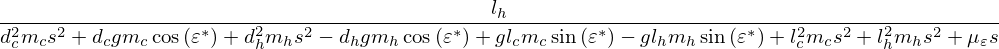

---


In [25]:
G_Fd_phi_symb = solve(F_lin[0], q_diff[0])[0]/Fd_diff ##:
G_Fs_eps_symb = solve(F_lin[1], q_diff[1], simplify=False)[0]/Fs_diff ##:

In [26]:
deg = 3.14/180

In [27]:
G_Fs_eps = lambda eps_op_val: symbolic_to_tf(G_Fs_eps_symb.subs(param_subs).subs(eps_op, eps_op_val))
ctr.pole(G_Fs_eps(10*deg))

array([-0.04533318+1.11985496j, -0.04533318-1.11985496j])

In [28]:
G_Fd_phi = lambda eps_op_val: symbolic_to_tf(G_Fd_phi_symb.subs(param_subs).subs(eps_op, eps_op_val))
ctr.pole(G_Fd_phi(10*deg))

array([-1.43952869,  0.57178237])

In [29]:
Fs_op_val = g/lh*((mc*dc - mh*dh)*sin(eps_op)+(mh*lh-mc*lc)*cos(eps_op))
G_phi_lamb_symb = solve(F_lin[2].subs(Fd_diff, 0), q_diff[2], simplify=False)[0].subs(Fs_op, Fs_op_val)/q_diff[0]

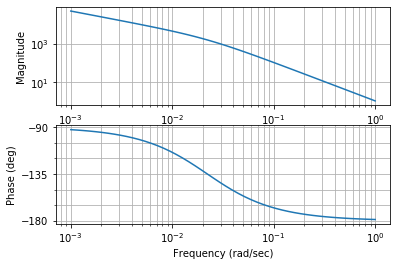

In [30]:
G_phi_lamb = lambda eps_op_val: symbolic_to_tf(G_phi_lamb_symb.subs(param_subs).subs(eps_op, eps_op_val))
_ = ctr.bode_plot(G_phi_lamb(10*deg))

In [31]:
def pid_tf(kp, ki, kd):
    return ctr.tf([kd, kp, ki], [1, 0])

In [32]:
pid_eps = pid_tf(15, 0.1, 7)
pid_lamb = pid_tf(1.5, 0.5, 2)
pid_phi = pid_tf(4, 0.1, 2)

In [33]:
eps_controlled = ctr.feedback(pid_eps * G_Fs_eps(0*deg))
phi_controlled = ctr.feedback(pid_phi * G_Fd_phi(0*deg))
lamb_controlled = ctr.feedback(pid_lamb * G_phi_lamb(0*deg))

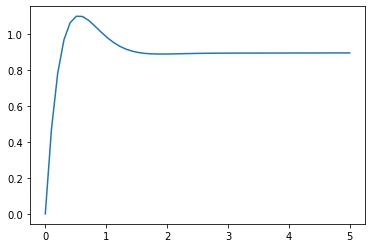

In [34]:
T, yout = ctr.step_response(eps_controlled, np.linspace(0, 5))
plt.plot(T, yout)

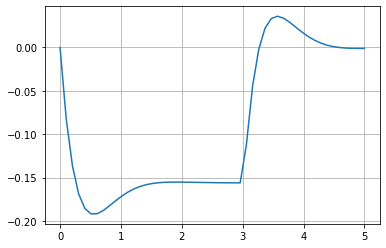

In [35]:
T = np.linspace(0, 5)
u = np.array([-10*deg if t < 3 else 0 for t in T])
T, yout, xout = ctr.forced_response(eps_controlled, T=T, U=u)
plt.plot(T, yout)
plt.grid()

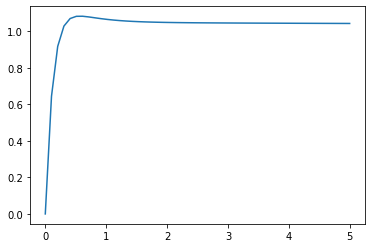

In [36]:
T, yout = ctr.step_response(phi_controlled, np.linspace(0, 5))
plt.plot(T, yout)

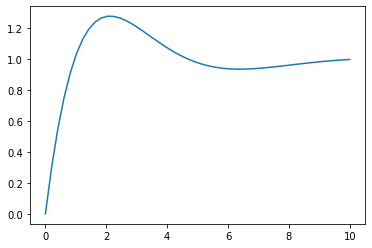

In [37]:
T, yout = ctr.step_response(lamb_controlled, np.linspace(0, 10))
plt.plot(T, yout)

In [38]:
lamb_controlled


      1.381 s^2 + 1.036 s + 0.3453
-----------------------------------------
0.8566 s^3 + 1.399 s^2 + 1.036 s + 0.3453

In [39]:
ctr.pole(G_phi_lamb(0))

array([-0.02101339,  0.        ])

In [40]:
ctr.pole(G_Fs_eps(0))

array([-0.04533318+1.19187651j, -0.04533318-1.19187651j])

In [41]:
ctr.pole(G_Fd_phi(0))

array([-1.44581565,  0.57806934])

In [47]:
p_eps_1 = M_diag[1, 1]
p_eps_2 = dc*mc-dh*mh*cos(phi)
p_lamb_1 = M_diag[2, 2]

In [50]:
p_eps_1.subs(param_subs).subs(phi, 0) ##:
p_eps_1.subs(param_subs).subs(phi, pi/2) ##:

p_eps_2.subs(param_subs).subs(phi, 0) ##:
p_eps_2.subs(param_subs).subs(phi, pi/2) ##:

p_lamb_1.subs(param_subs).subs(eps, 0).subs(phi, 0) ##:
p_lamb_1.subs(param_subs).subs(eps, 0).subs(phi, pi/2) ##:

---


---


---


---


---


---


In [52]:
0.856 / 0.819

abc := 
      1.381 s^2 + 1.036 s + 0.3453
-----------------------------------------
0.8566 s^3 + 1.399 s^2 + 1.036 s + 0.3453

---


(ctr.pole(abc)) := array([-0.73413559+0.j        , -0.44968053+0.58897955j, -0.44968053-0.58897955j])

---


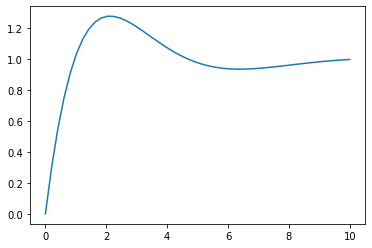

In [57]:
abc = ctr.feedback(pid_lamb * G_phi_lamb(0*deg)) ##:
ctr.pole(abc) ##:
T, yout = ctr.step_response(abc, np.linspace(0, 10))
plt.plot(T, yout)

abc2 := 
      1.976 s^2 + 1.482 s + 0.494
----------------------------------------
0.7281 s^3 + 1.994 s^2 + 1.482 s + 0.494

---


(ctr.pole(abc2)) := array([-1.82818721+0.j        , -0.45516025+0.40488591j, -0.45516025-0.40488591j])

---


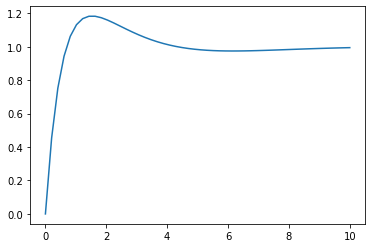

In [58]:
abc2 = ctr.feedback(pid_lamb * G_phi_lamb(20*deg)) ##:
ctr.pole(abc2) ##:
T, yout = ctr.step_response(abc2, np.linspace(0, 10))
plt.plot(T, yout)

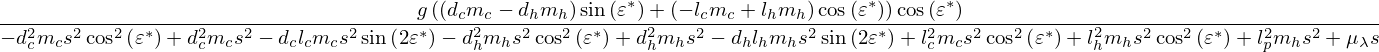

In [59]:
G_phi_lamb_symb

In [62]:
epss = np.linspace(-20*deg, 20*deg, 10)

poles = []
for eps_i in epss:
    pole_i = ctr.pole(ctr.feedback(pid_lamb*G_phi_lamb(eps_i)))
    poles.append(pole_i)

In [66]:
poles_array = np.array(poles)
poles_sorted = poles_array.copy()
poles_sorted[5:,0:2] = poles_array[5:,1:]
poles_sorted[5:,2] = poles_array[5:,0]

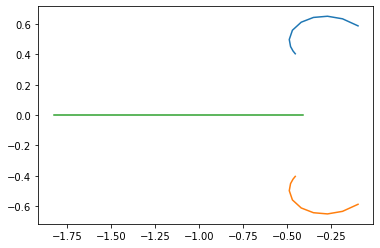

In [70]:
plt.figure()
plt.plot(np.real(poles_sorted[:,0]), np.imag(poles_sorted[:,0]))
plt.plot(np.real(poles_sorted[:,1]), np.imag(poles_sorted[:,1]))
plt.plot(np.real(poles_sorted[:,2]), np.imag(poles_sorted[:,2]))

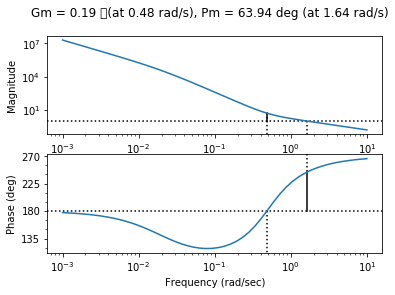

In [74]:
_ = ctr.bode_plot(pid_lamb * G_phi_lamb(0*deg), margins=True)

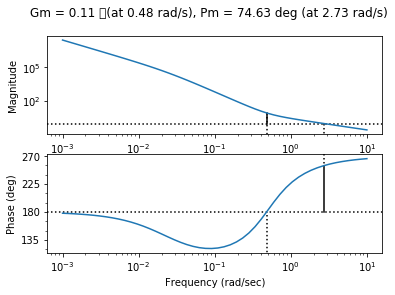

In [75]:
_ = ctr.bode_plot(pid_lamb * G_phi_lamb(20*deg), margins=True)

# Observability analysis

In [16]:
phioff = Symbol('\\varphi_o')
xo = Matrix([phi, eps, lamb, phid, epsd, lambd, phioff])


In [22]:
F_sol = solve(F, [phidd, epsdd, lambdd])

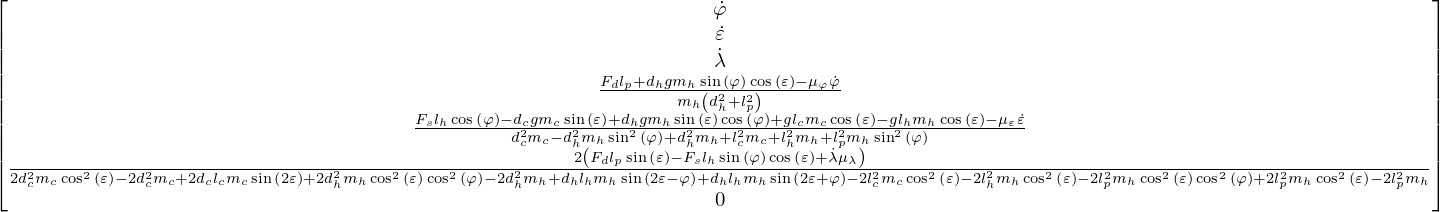

---


In [23]:
Fo = Matrix([phid, epsd, lambd, F_sol[phidd], F_sol[epsdd], F_sol[lambdd], 0]) ##:

In [26]:
A = Fo.jacobian(xo).subs(param_subs)
C = Matrix([[1, 0, 0, 0, 0, 0, 1], [0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0]])
O = st.row_stack(C, C*A, C*A*A, C*A*A*A)

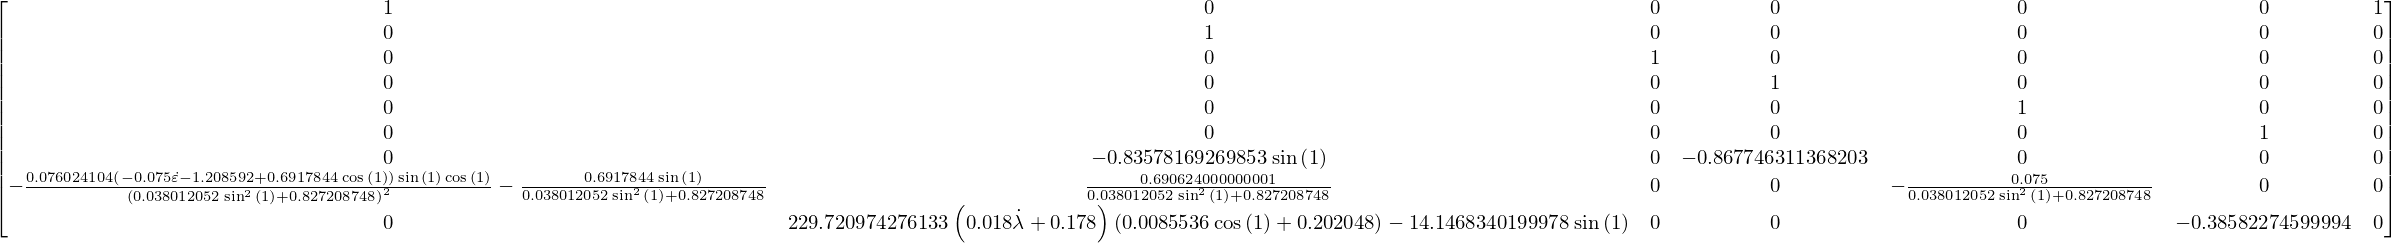

In [85]:
O.subs([(Fs, 1), (Fd, 1)]).subs([(phi, 1), (eps, pi/2), (lamb, 0)])

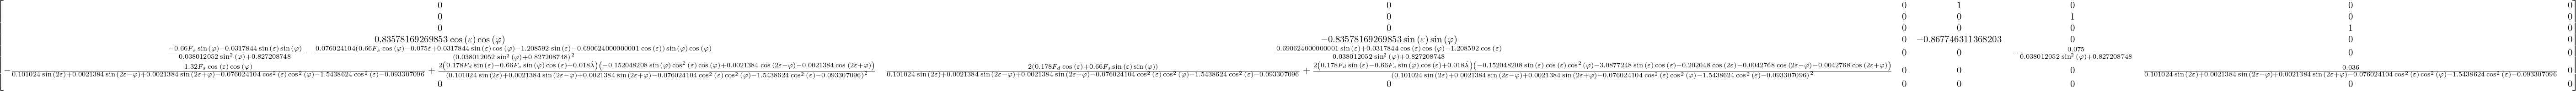

In [27]:
A

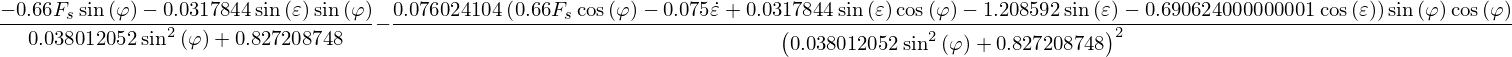

In [28]:
A[4, 0]

In [29]:
M = simplify(M)
for row in range(3):
    for col in range(3):
        print(f"m_{{{row+1}{col+1}}}(q) &= {latex(M[row, col])}\\\\")

m_{11}(q) &= m_{h} \left(d_{h}^{2} + l_{p}^{2}\right)\\
m_{12}(q) &= - d_{h} l_{h} m_{h} \sin{\left (\varphi \right )}\\
m_{13}(q) &= m_{h} \left(- d_{h}^{2} \sin{\left (\varepsilon \right )} + d_{h} l_{h} \cos{\left (\varepsilon \right )} \cos{\left (\varphi \right )} - l_{p}^{2} \sin{\left (\varepsilon \right )}\right)\\
m_{21}(q) &= - d_{h} l_{h} m_{h} \sin{\left (\varphi \right )}\\
m_{22}(q) &= d_{c}^{2} m_{c} + d_{h}^{2} m_{h} \cos^{2}{\left (\varphi \right )} + l_{c}^{2} m_{c} + l_{h}^{2} m_{h} - l_{p}^{2} m_{h} \cos^{2}{\left (\varphi \right )} + l_{p}^{2} m_{h}\\
m_{23}(q) &= m_{h} \left(d_{h}^{2} \cos{\left (\varepsilon \right )} \cos{\left (\varphi \right )} + d_{h} l_{h} \sin{\left (\varepsilon \right )} - l_{p}^{2} \cos{\left (\varepsilon \right )} \cos{\left (\varphi \right )}\right) \sin{\left (\varphi \right )}\\
m_{31}(q) &= m_{h} \left(- d_{h}^{2} \sin{\left (\varepsilon \right )} + d_{h} l_{h} \cos{\left (\varepsilon \right )} \cos{\left (\varphi \right )} - l_{p}^{2